# Human pose estimation with YoloV7

Unlike conventional Pose Estimation algorithms, **YOLOv7 pose is a single-stage multi-person keypoint detector**. It is similar to the bottom-up approach but heatmap free. It is an extension of the one-shot pose detector – YOLO-Pose. It has the best of both Top-down and Bottom-up approaches.
<br><br>
**YOLOv7 Pose is trained on the COCO dataset which has 17 landmark topologies**.<br>
It is implemented in PyTorch making the code super easy to customize as per your need.<br><br>
The pre trained keypoint detection model is **yolov7-w6-pose.pth**

<img src="https://learnopencv.com/wp-content/uploads/2022/10/coco-17-skeleton-topology.png" width="240">

<img src="https://learnopencv.com/wp-content/uploads/2022/08/yolov7-ms-coco-speed-ap-comparison.png" width="640">
<img src="https://learnopencv.com/wp-content/uploads/2022/08/yolov7-comparison.png" width="640">
<img src="https://learnopencv.com/wp-content/uploads/2022/08/yolov7-models-inference-speed-chart.png" width="640">

https://github.com/WongKinYiu/yolov7

In [ ]:
#!pip install moviepy

In [ ]:
#pip install --upgrade torchvision

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import sys
import torch
import time
import datetime

from torchvision import transforms
from PIL import Image
from moviepy.editor import *

%matplotlib inline

In [ ]:
sys.version

'3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]'

In [ ]:
print(datetime.datetime.today())

2023-08-17 02:53:46.446251


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Cloning YoloV7 repo

In [ ]:
YOLO_DIR = 'yolov7'

In [ ]:
if not os.path.exists(YOLO_DIR):
    print("Starting to clone the YoloV7 repo\n")
    !git clone https://github.com/WongKinYiu/yolov7.git
    print("\nDone")

if os.path.exists(YOLO_DIR):
    print("\nDirectory is present:\n")
    !ls yolov7

Starting to clone the YoloV7 repo

Cloning into 'yolov7'...
remote: Enumerating objects: 1191, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1191 (delta 2), reused 6 (delta 2), pack-reused 1185
Receiving objects: 100% (1191/1191), 74.23 MiB | 38.04 MiB/s, done.
Resolving deltas: 100% (511/511), done.

Done

Directory is present:

cfg	detect.py  hubconf.py  models	  requirements.txt  tools	  utils
data	export.py  inference   paper	  scripts	    train_aux.py
deploy	figure	   LICENSE.md  README.md  test.py	    train.py


In [ ]:
RESULTS_DIR = 'results'

if not os.path.exists(RESULTS_DIR):
    print("Creating the directory:", RESULTS_DIR)
    os.mkdir(RESULTS_DIR)
    print("Done")

Creating the directory: results
Done


## 2. YoloV7 models

Models:
https://github.com/WongKinYiu/yolov7/#performance

In [ ]:
YOLOV7_MODEL = [
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7x.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-d6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt",
]

In [ ]:
print("List of YoloV7 models:\n")
YOLOV7_MODEL

List of YoloV7 models:



['https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7x.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-d6.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt']

In [ ]:
def get_yolov7_model(modelistid=1):
    """
    Download YoloV7 model from a yoloV7 model list
    """
    modelid = YOLOV7_MODEL[modelistid]

    if not os.path.exists(modelid):
        print("Downloading the model:",
              os.path.basename(modelid), "from:", modelid)
        urllib.request.urlretrieve(modelid,
                                   filename=os.path.basename(modelid))
        print("Done\n")
        !ls yolo*.pt -lh

    if os.path.exists(modelid):
        print("Downloaded model files:")
        !ls yolo*.pt -lh

## 3. Using YoloV7 models on images

In [ ]:
os.chdir(YOLO_DIR)

In [ ]:
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def image_view(imagefile, w=15, h=10):
    """
    Displaying an image from an image file
    """
    %matplotlib inline
    plt.figure(figsize=(w, h))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(cv2.imread(imagefile),
                            cv2.COLOR_BGR2RGB))

In [ ]:
def loading_yolov7_model(yolomodel):
    """
    Loading yolov7 model
    """
    print("Loading model:", yolomodel)
    model = torch.load(yolomodel, map_location=device)['model']
    model.float().eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)

    return model, yolomodel

In [35]:
def running_inference(image):
    """
    Running yolov7 model inference
    """
    image = letterbox(image, 960,
                      stride=64,
                      auto=True)[0]  # shape: (567, 960, 3)
    image = transforms.ToTensor()(image)  # torch.Size([3, 567, 960])

    if torch.cuda.is_available():
        image = image.half().to(device)

    image = image.unsqueeze(0)  # torch.Size([1, 3, 567, 960])

    with torch.no_grad():
        output, _ = model(image)

    return output, image

### 3.1 Using the tiny Yolov7 model

In [ ]:
YOLOV7_MODEL[0]

'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt'

In [ ]:
get_yolov7_model(0)

Done

-rw-r--r-- 1 root root 13M Aug 17 02:54 yolov7-tiny.pt


In [ ]:
YOLOV7MODEL = os.path.basename(YOLOV7_MODEL[0])

try:
    print("Loading the model...")
    model, yolomodel = loading_yolov7_model(yolomodel=YOLOV7MODEL)
    print("Using the", YOLOV7MODEL, "model")
    print("Done")

except:
    print("[Error] Cannot load the model", YOLOV7MODEL)

Loading the model...
Loading model: yolov7-tiny.pt
Using the yolov7-tiny.pt model
Done


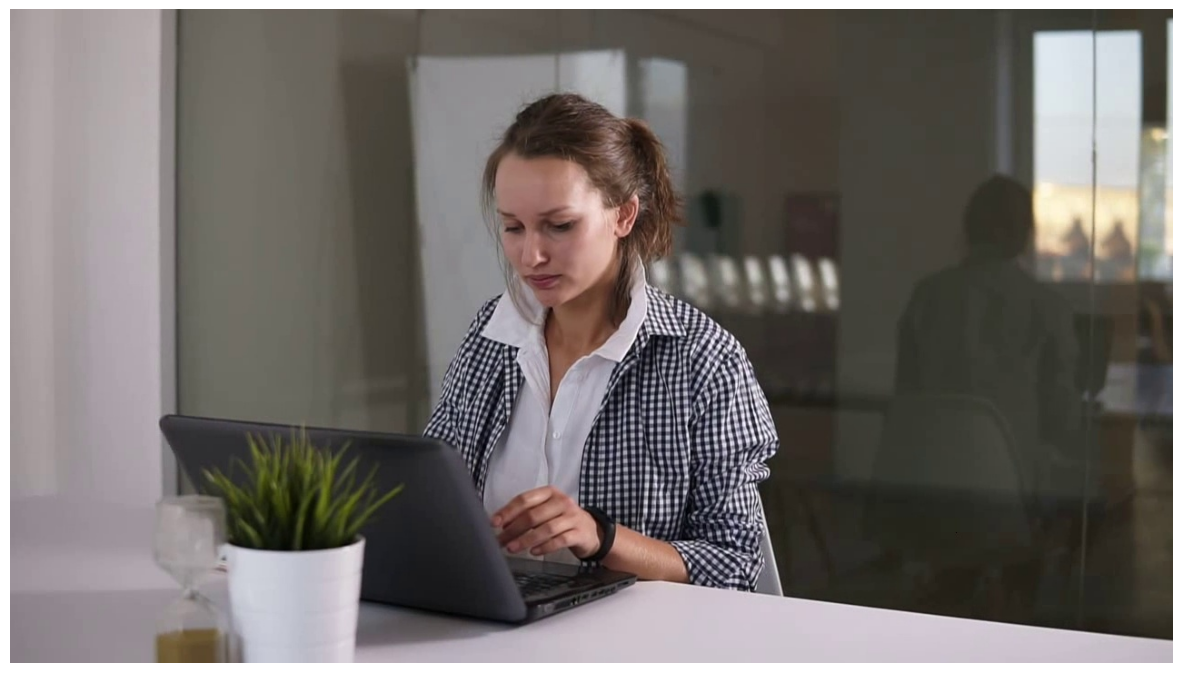

In [ ]:
image_view("/content/video23.jpg")

In [ ]:
!python detect.py --weights ./yolov7-tiny.pt --conf 0.2 --img-size 640 --source /content/video23.jpg

Namespace(weights=['./yolov7-tiny.pt'], source='/content/video23.jpg', img_size=640, conf_thres=0.2, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-126-g84932d7 torch 2.0.1+cu118 CPU

Fusing layers... 
Model Summary: 200 layers, 6219709 parameters, 229245 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2 persons, 1 wine glass, 2 chairs, 1 potted plant, 1 laptop, 1 vase, Done. (196.0ms) Inference, (22.8ms) NMS
 The image with the result is saved in: ru

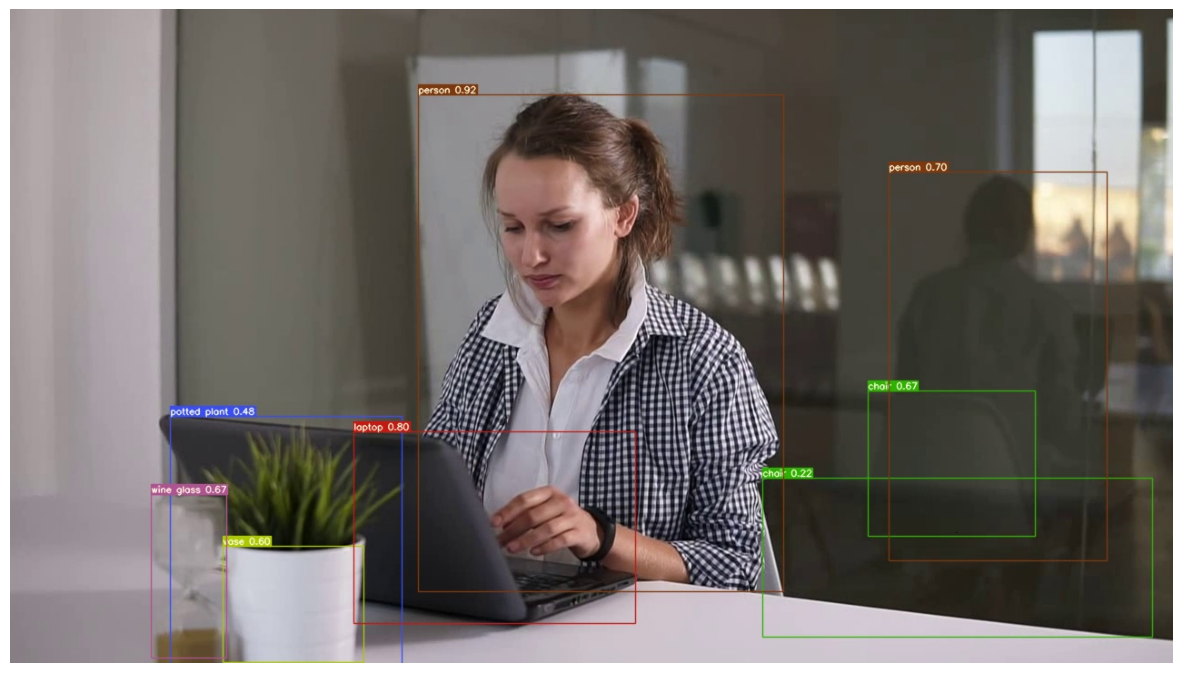

In [ ]:
image_view("runs/detect/exp/video23.jpg")

### 3.2 Using the yolov7-w6-pose model

In [ ]:
YOLOV7_MODEL[7]

'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt'

In [ ]:
get_yolov7_model(7)

Done

-rw-r--r-- 1 root root  13M Aug 17 02:54 yolov7-tiny.pt
-rw-r--r-- 1 root root 154M Aug 17 02:56 yolov7-w6-pose.pt


In [ ]:
YOLOV7MODEL = os.path.basename(YOLOV7_MODEL[7])

try:
    print("Loading the model...")
    model, yolomodel = loading_yolov7_model(yolomodel=YOLOV7MODEL)
    print("Using the", YOLOV7MODEL, "model")
    print("Done")

except:
    print("[Error] Cannot load the model", YOLOV7MODEL)

Loading the model...
Loading model: yolov7-w6-pose.pt
Using the yolov7-w6-pose.pt model
Done


## Exploring output keypoints
![Exploring output keypoints](https://miro.medium.com/v2/resize:fit:720/format:webp/1*PM5Q-58eNOWdoLogVKCGnQ.png)

In [70]:
def draw_keypoints(output, image, confidence=0.25, threshold=0.65):
    """
    Draw YoloV7 pose keypoints
    """
    output = non_max_suppression_kpt(
        output,
        confidence,  # Confidence Threshold
        threshold,  # IoU Threshold
        nc=model.yaml['nc'],  # Number of Classes
        nkpt=model.yaml['nkpt'],  # Number of Keypoints
        kpt_label=True)

    with torch.no_grad():
        keypoints = output_to_keypoint(output)

    nimg = image[0].permute(1, 2, 0) * 255
    nimg = cv2.cvtColor(nimg.cpu().numpy().astype(np.uint8), cv2.COLOR_RGB2BGR)

    for idx in range(keypoints.shape[0]):
        joints = keypoints[idx, 7:].T
        joint_number = 12
        joints[joint_number*3:joint_number*3 + 3] = 0
        plot_skeleton_kpts(nimg, joints, 3)

    return keypoints, nimg

In [71]:
imagefile = "/content/messi.jpg"
output, image = running_inference(cv2.imread(imagefile))


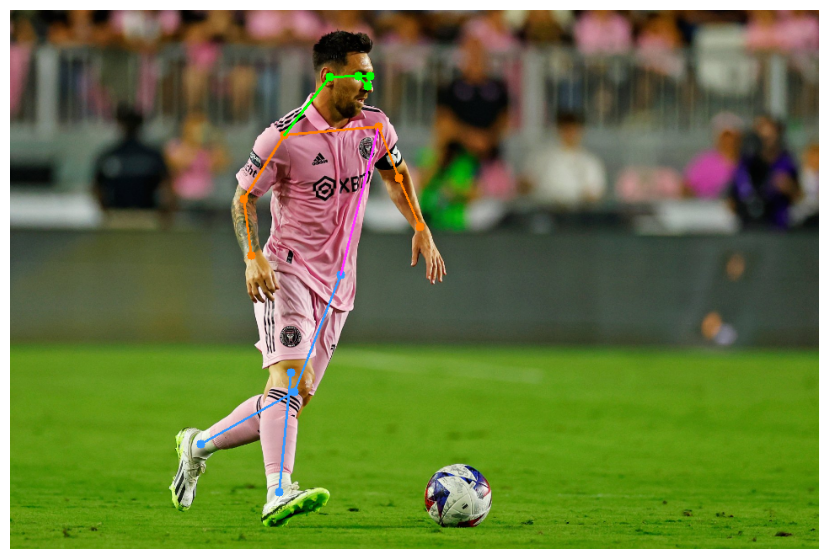

In [72]:
keypoints, pose_image = draw_keypoints(output, image, confidence=0.5, threshold=0.65)

plt.figure(figsize=(30, 7))
plt.axis("off")
plt.imshow(pose_image)

In [56]:
joints = keypoints[0, 7:].T

In [63]:
original_array[3:6] = 0

array([     424.31,      90.504,     0.99164,      427.29,      78.916,     0.60675,      413.88,      78.975,      0.9939,      423.01,      80.491,    0.012339,      379.73,      79.517,     0.84012,      437.78,      138.58,     0.97625,      325.12,      148.02,     0.98192,      461.59,      199.98,     0.94577,
            277.55,      224.81,     0.96564,      486.87,      257.46,     0.93691,      286.71,      291.81,     0.95572,      392.13,      314.14,     0.98808,      327.58,      308.47,     0.98924,      337.35,      453.84,     0.97448,      333.85,      430.39,     0.97797,      226.79,      515.73,     0.89912,
            319.91,       572.3,     0.90688])

## 4. Analysing a video with yolov7-w6-pose

In [ ]:
def yoloV7_pose_video(videofile, confidence=0.25, threshold=0.65):
    """
    Processing the video using YoloV7
    """
    start = time.time()
    # Reading video
    video = VideoFileClip(videofile)

    # Stats
    duration = video.duration
    fps = round(video.fps)
    nbframes = round(duration * fps)

    print("Processing video:", videofile, "using confidence min =", confidence,
          "and threshold =", threshold)
    print("\nVideo duration =", duration, "seconds")
    print("FPS =", fps)
    print("Total number of frames =", nbframes, "\n")

    # Capture the results frames into a video
    capture = cv2.VideoCapture(videofile)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    outputvideofile = "../results/result_" + os.path.basename(videofile)
    outvideo = cv2.VideoWriter(outputvideofile, fourcc, 30.0,
                               (int(capture.get(3)), int(capture.get(4))))
    idx = 1

    while capture.isOpened():
        (ret, frame) = capture.read()

        if ret == True:
            if idx % fps == 1:
                nbremainframes = nbframes - idx
                pctdone = round(idx / nbframes * 100)
                print("Processed frames =", f"{idx:06}",
                      "| Number of remaining frames:", f"{nbremainframes:06}",
                      "| Done:", pctdone, "%")

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            output, frame = running_inference(frame)
            frame = draw_keypoints(output, frame, confidence, threshold)
            frame = cv2.resize(frame,
                               (int(capture.get(3)), int(capture.get(4))))

            cv2.imwrite(
                "results/videoframe_" + os.path.basename(videofile) + '_' +
                str(f"{idx:06}.jpg"), frame)
            outvideo.write(frame)  # output to video file

        else:
            break

        idx += 1

    processed_time = round(time.time() - start)
    time_per_frame = round(processed_time / (idx - 1), 2)
    print("\nDone in", processed_time, "seconds")
    print("Time per frame =", time_per_frame, "seconds")
    print("\nSaved video:", outputvideofile)

    capture.release()
    outvideo.release()

    return outputvideofile

### 4.1 Test 1

In [ ]:
!ls ../videos/football.mp4 -lh

-rwxrwxrwx 1 root root 897K Oct 26 14:59 ../videos/football.mp4


In [ ]:
football_vid = "../videos/football.mp4"
football_video = yoloV7_pose_video(football_vid)

Processing video: ../videos/football.mp4 using confidence min = 0.25 and threshold = 0.65

Video duration = 13.1 seconds
FPS = 10
Total number of frames = 131 

Processed frames = 000001 | Number of remaining frames: 000130 | Done: 1 %
Processed frames = 000011 | Number of remaining frames: 000120 | Done: 8 %
Processed frames = 000021 | Number of remaining frames: 000110 | Done: 16 %
Processed frames = 000031 | Number of remaining frames: 000100 | Done: 24 %
Processed frames = 000041 | Number of remaining frames: 000090 | Done: 31 %
Processed frames = 000051 | Number of remaining frames: 000080 | Done: 39 %
Processed frames = 000061 | Number of remaining frames: 000070 | Done: 47 %
Processed frames = 000071 | Number of remaining frames: 000060 | Done: 54 %
Processed frames = 000081 | Number of remaining frames: 000050 | Done: 62 %
Processed frames = 000091 | Number of remaining frames: 000040 | Done: 69 %
Processed frames = 000101 | Number of remaining frames: 000030 | Done: 77 %
Proce

In [ ]:
VideoFileClip(football_video).ipython_display(width=640)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### 4.2 Test 2

In [ ]:
!ls ../videos/tennis.mp4 -lh

-rwxrwxrwx 1 root root 779K Oct 26 14:59 ../videos/tennis.mp4


In [ ]:
tennis_vid = "../videos/tennis.mp4"
tennis_video = yoloV7_pose_video(tennis_vid)

Processing video: ../videos/tennis.mp4 using confidence min = 0.25 and threshold = 0.65

Video duration = 14.6 seconds
FPS = 25
Total number of frames = 365 

Processed frames = 000001 | Number of remaining frames: 000364 | Done: 0 %
Processed frames = 000026 | Number of remaining frames: 000339 | Done: 7 %
Processed frames = 000051 | Number of remaining frames: 000314 | Done: 14 %
Processed frames = 000076 | Number of remaining frames: 000289 | Done: 21 %
Processed frames = 000101 | Number of remaining frames: 000264 | Done: 28 %
Processed frames = 000126 | Number of remaining frames: 000239 | Done: 35 %
Processed frames = 000151 | Number of remaining frames: 000214 | Done: 41 %
Processed frames = 000176 | Number of remaining frames: 000189 | Done: 48 %
Processed frames = 000201 | Number of remaining frames: 000164 | Done: 55 %
Processed frames = 000226 | Number of remaining frames: 000139 | Done: 62 %
Processed frames = 000251 | Number of remaining frames: 000114 | Done: 69 %
Process

In [ ]:
VideoFileClip(tennis_video).ipython_display(width=640)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### 4.3 Test 3

In [ ]:
!ls ../videos/sport.mp4 -lh

-rwxrwxrwx 1 root root 883K Oct 27 08:08 ../videos/sport.mp4


In [ ]:
sport_vid = "../videos/sport.mp4"
sport_video = yoloV7_pose_video(sport_vid)

Processing video: ../videos/sport.mp4 using confidence min = 0.25 and threshold = 0.65

Video duration = 23.53 seconds
FPS = 10
Total number of frames = 235 

Processed frames = 000001 | Number of remaining frames: 000234 | Done: 0 %
Processed frames = 000011 | Number of remaining frames: 000224 | Done: 5 %
Processed frames = 000021 | Number of remaining frames: 000214 | Done: 9 %
Processed frames = 000031 | Number of remaining frames: 000204 | Done: 13 %
Processed frames = 000041 | Number of remaining frames: 000194 | Done: 17 %
Processed frames = 000051 | Number of remaining frames: 000184 | Done: 22 %
Processed frames = 000061 | Number of remaining frames: 000174 | Done: 26 %
Processed frames = 000071 | Number of remaining frames: 000164 | Done: 30 %
Processed frames = 000081 | Number of remaining frames: 000154 | Done: 34 %
Processed frames = 000091 | Number of remaining frames: 000144 | Done: 39 %
Processed frames = 000101 | Number of remaining frames: 000134 | Done: 43 %
Processe

In [ ]:
VideoFileClip(sport_video).ipython_display(width=640)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
